In [1]:
from balloon_initial import *

In [2]:
from datastructures.api import (edges_no_param, addobj, addineq, merge, 
setsolvefor, var_params, copy_dicts, OPT)
from datastructures.graphutils import flatten_tree, all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign, min_arc_set
from datastructures.operators import reformulate, invert_edges
from datastructures.transformations import transform_components
from datastructures.rendering import render_incidence
from datastructures.runpipeline import model_to_problem
from datastructures.postprocess import print_outputs
import openmdao.api as om

In [3]:
from ipywidgets import interact

### Configuration

In [4]:
global run_optimal_structure
def f(optimal_structure):
    global run_optimal_structure
    run_optimal_structure=optimal_structure
interact(f, optimal_structure=True);

interactive(children=(Checkbox(value=True, description='optimal_structure'), Output()), _dom_classes=('widget-…

### Load structure of model

In [5]:
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

### Restructure design model

We force variables from the constraints to be inputs:

In [6]:
not_input = ['T_z','p_z','g_z',r'\rho_z', r'm_{rz}', 'm_{r0}', 'h_z', 'r_z', 'V_z', 'L_z', 'W_z', 'W_0']
not_output = []#[r'm_{rz}', 'm_{r0}']

In [7]:
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [8]:
cycles, elimset, _ = min_arc_set(edges_left_right, outset_initial, varidxs, eqnidxs)
outset_opt = {key:val for key,val in outset_initial.items() if key not in elimset}

### Build structure of optimization model

In [9]:
outset_opt = None
if run_optimal_structure:
    outset_opt = {right:left for left, right in edges_left_right 
                  if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [9]:
tree_for_reformulation = flatten_tree(tree, 'opt')
not_outputs = var_params(model, edges)
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', not_outputs=not_outputs,
                                              solveforvars=2, mdf=True) # For OPT do not have subproblems so no need to set mdf=True/False
edges_minassign_noparam = edges_no_param(model, edges_minassign)

In [10]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [11]:
#from datastructures.execution import Component
#import sympy as sp
#newcomps2 = newcomps[0:4]+[Component.fromsympy(0.620350490899399*abs(V_0)**(1/3), tovar=r_0, component=20)]+[newcomps[5]]

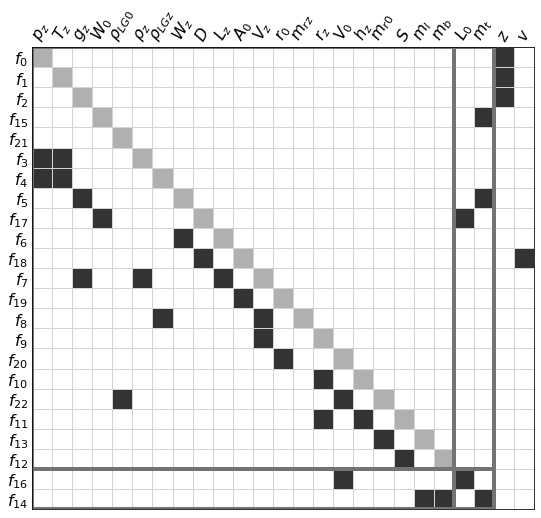

In [12]:
_, ax = render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

### Optimization formulation

In [13]:
opt = addsolver(m, name="opt", idbyname=True)
addobj(opt, m_t)
if run_optimal_structure:
    addineq(opt, 0.1-vr)
    addineq(opt, 0.1-D)

In [14]:
solvefor_init = [vr]
varoptions_init = {vr:[0.1,10]}# Pcomms:[10,100]}

In [15]:
solvefor_opt = [m_t]
varoptions_opt = {m_t:[9000]}

In [16]:
solvefor, varoptions = ((solvefor_init, varoptions_init), (solvefor_opt, varoptions_opt))[run_optimal_structure]
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT} #'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}

In [17]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)
edges_ma_opt_noparam = edges_no_param(model, edges_ma_opt)

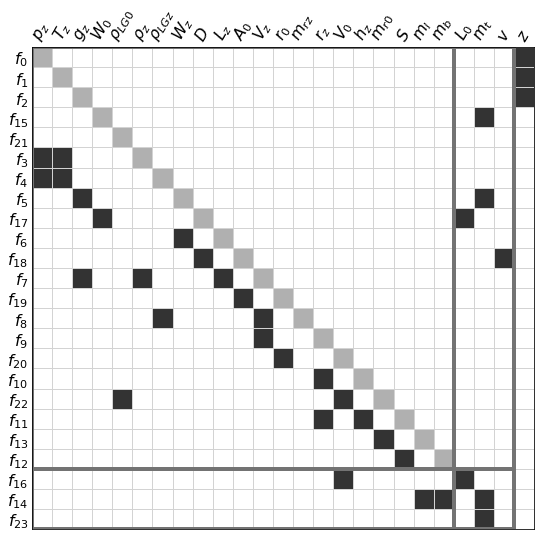

In [18]:
_, ax = render_incidence(edges_ma_opt_noparam, tree_ma_opt, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

In [19]:
from datastructures.workflow import get_f
from datastructures.graphutils import all_component_nodes
#[get_f(model.components+newcomps, edges_ma_opt)(elt) for elt in all_component_nodes(edges_ma_opt)]

In [22]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [23]:
# vs = []
# for mti in np.linspace(9000,10000):
#     prob.set_val('m_t', mti)
#     prob.run_model()
#     vs.append(prob.get_val('v')[0])
# import matplotlib.pyplot as plt
# plt.plot(np.linspace(9000,10000), np.log(np.array(vs)+0.1))

In [24]:
# prob.set_val('m_t', 9000)
# prob.run_model()
# prob.get_val('v')

In [25]:
prob.get_val('v')

array([6])

In [27]:
prob.run_driver()


==
s2
==
NL: NewtonSolver 'NL: Newton' on system 's2' failed to converge in 10 iterations.

==
s2
==
NL: NewtonSolver 'NL: Newton' on system 's2' failed to converge in 10 iterations.
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 98299203.8263966
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


True

In [26]:
#print_outputs(model, prob, namingfunc, rounding=3)

In [24]:
#prob.driver.pyopt_solution.optInform['value']

In [25]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals']);

----------------
Design Variables
----------------
name  val              size  lower   upper  
----  ---------------  ----  ------  ----- 
m_t   [9317.23705048]  1     9000.0  1e+30  

-----------
Constraints
-----------
name   val                size  lower   upper  equals  
-----  -----------------  ----  ------  -----  ------ 
neq24  [-1.65891828e-10]  1     -1e+30  0.0    None    

----------
Objectives
----------
name   val              size  
-----  ---------------  ---- 
obj23  [9317.23705048]  1     

